<a href="https://colab.research.google.com/github/TuringCollegeSubmissions/tjanus-DS.4.3/blob/master/435_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Deep Learning

## Sprint 3: Practical Deep Learning

## Age and Gender classification

<div style="text-align:center;margin-top:10px">
<div><img style="width:400px" src="https://ec.europa.eu/echo/sites/echo-site/files/GA%20marker%20image.jpg"></img><div>
<div style="margin-bottom:20px; color:rgb(117, 117, 117);font-size:12px;">Source: https://ec.europa.eu/</div>
</div>

## Background

Congratulations on reaching your last project. We will try to put into practice the concepts we learned so far.

In this lesson, we will take two fairly simple problems - gender classification and age classification from an up-close image of a person. But instead of making two different models, your task will be to make one model that does both of these tasks. Moreover, you will then analyze the model from the ethical point of view and see what sort of dangers and caveats such models can have.

The exercise today is to train a multi-objective image classifier using data from https://www.kaggle.com/jangedoo/utkface-new  
You will train a single model that can predict gender and age.

Find out more about multi-task learning  
https://ruder.io/multi-task/  
https://www.youtube.com/watch?v=UdXfsAr4Gjw

## get data

Using Kaggle api get all of the pictures

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jangedoo/utkface-new
! mkdir data
! unzip utkface-new.zip -d data

## imports

In [ ]:
! pip install pytorch_lightning -q
! pip install neptune-client -q

In [4]:
from fastai import *
from fastai.vision import *

import numpy as np
import pandas as pd
import PIL

from sklearn.model_selection import train_test_split

import torchvision
from torchvision import transforms

from random import randrange

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [7]:
RANDOM = 42
IMG_SIZE = 224 # for resnet34
BATCH_SIZE = 32

## EDA

First we check folders visually to notice any abnormalities. 

After the reviw, pictures seem fine. 

We'll split the data into 3 parts

In [8]:
images = get_image_files("/content/data/UTKFace")

len(images)

23708

In [9]:
img_train, img_valid = train_test_split(
    images, test_size=0.2, random_state=RANDOM)

img_valid, img_test = train_test_split(
    img_valid, test_size=0.2, random_state=RANDOM)

In [10]:
# sizes of data splits
len(img_train), len(img_valid), len(img_test)

(18966, 3793, 949)

There is a need to extract labels from the file names and make it into dataframe for EDA

In [11]:
def generic_transform(images):
    df = pd.DataFrame(images, columns=["name"])
    df.name = df.name.apply(str)
    df["label"] = df.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])
    df["label"] = df.label.apply(lambda x: re.sub("_"," ", x))
    df["age"] = df.label.apply(lambda x: int(x.split(" ")[0]))
    df["gender"] = df.label.apply(lambda x: int(x.split(" ")[1]))
    return df

In [12]:
df_train = generic_transform(img_train)
df_valid = generic_transform(img_valid)
df_test = generic_transform(img_test)

In [13]:
df_train.head(2)

,name,label,age,gender
0,/content/data/UTKFace/29_0_2_20170116170817714...,29 0 2,29,0
1,/content/data/UTKFace/28_0_4_20170117202418494...,28 0 4,28,0


### age

Check our distributions. Plotting validation set to be sure that it's distribution is similar. 

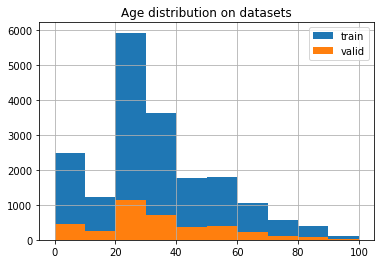

In [14]:
bins = [i*10 for i in range(11)]
df_train.age.hist(bins=bins)
df_valid.age.hist(bins=bins)
plt.title("Age distribution on datasets")
plt.legend(["train","valid"])

Text(0.5, 1.0, 'Logged age distribution on datasets')

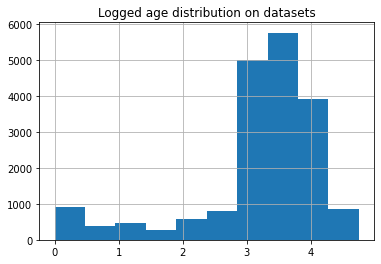

In [15]:
np.log(df_train.age).hist()
plt.title("Logged age distribution on datasets")

Distributions look about equall. I'm concerned about the spike of pictures containing 30 year olds. 

We will keep it as it is but we should keep this distribution in mind when we'll evaluate the results.

### sex

In [16]:
df_train.gender.unique(), df_valid.gender.unique(), df_test.gender.unique()

(array([0, 1]), array([1, 0]), array([1, 0]))

Text(0.5, 1.0, 'sex distribution')

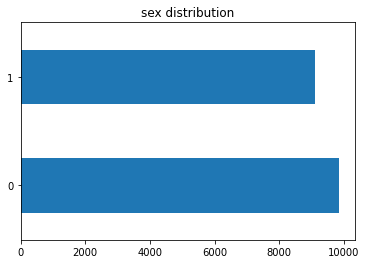

In [17]:
(df_train.gender.value_counts()).plot.barh()
plt.title("sex distribution")

Seems ok

## dataset

creating dataset which returns age and gender and also has a way to create a picture 

In [21]:
class MTDataset(Dataset):

    def __init__(self, df, transformer, size=64):
        self.paths = list(df.name)
        self.labels = list(df.label)
        self.tfms = transformer
        self.size = size

        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = PIL.Image.open(self.paths[idx]).convert("RGB")
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        img = img.apply_tfms(self.tfms, size=self.size)
        img = self.norm(img.data)
        
        labels = self.labels[idx].split(" ")
        
        age = torch.tensor(float(labels[0]), dtype=torch.float32)
        # log the age to make it more sensable
        age = np.log(age)
        gender = torch.tensor(float(labels[1]), dtype=torch.float32)

        return {"img": img.data, "labels":{"age": age, "gender": gender}}

    def show(self, idx):
        data = self.__getitem__(idx)
        x = data["img"]
        age, gender = data["labels"]["age"], data["labels"]["gender"]
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means) * 255).astype(np.uint8)
        plt.imshow(img)
        plt.title(f"{int(np.exp(age))} {gender.item()}")

In [22]:
# creating the dataloaders

transformations = get_transforms()

train_dataset = MTDataset(df_train, transformations[0], size=IMG_SIZE)
valid_dataset = MTDataset(df_valid, transformations[1], size=IMG_SIZE)
test_dataset = MTDataset(df_test, transformations[1], size=IMG_SIZE)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=3)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                              num_workers=3)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                              num_workers=3)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


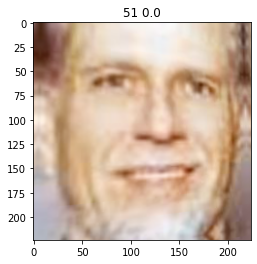

In [23]:
train_dataset.show(randrange(len(df_train)))

## modeling

In [24]:
# check for the correct dimensions
train_dataset[0]['img'].shape

torch.Size([3, 224, 224])

In [ ]:
# using neptune ai for logging
import neptune.new as neptune
def start_neptune():
    with open("/content/neptune-secret.txt", 'r') as f:
        key = f.readlines()

    run = neptune.init(
        project=key[0][:-1],
        api_token=key[1],)
    return run

In [25]:
class MTLModel(pl.LightningModule):

    def __init__(self, base_lr=1e-3):
        super().__init__()
        # making the base model
        resnet34_base = torchvision.models.resnet34(pretrained=True)
        resnet34_tune = torch.nn.Sequential(*(list(resnet34_base.children())[:-1]))

        self.base_model = resnet34_tune 
        self.age = nn.Linear(512, 1)
        self.gender = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())
        
        self.MSELoss = nn.MSELoss()
        self.CrossEntropy = nn.BCELoss()

        self.transformations = get_transforms()
        self.lr = base_lr

        self.base_grad(requires_grad = False)

    def base_grad(self, requires_grad: bool):
        for param in self.base_model.parameters():
            param.requires_grad = requires_grad

    def forward(self, features):
        x_base = self.base_model(features).view(-1, 512)
        age = self.age(x_base)
        gender = self.gender(x_base)

        return age, gender

    def training_step(self, batch, batch_idx):
        features, labels = batch["img"], batch["labels"]
        age, gender = self.forward(features)
        
        age_loss = F.mse_loss(age, labels["age"])
        gender_loss = F.binary_cross_entropy(gender.squeeze(1), labels["gender"])
        loss = age_loss + gender_loss


        run["train_loss"].log(loss)
        run["age_loss"].log(age_loss)
        run["gender_loss"].log(gender_loss)

        self.log("train_loss", loss)
        return loss
    
    
    def validation_step(self, val_batch, batch_idx):
        features, labels = val_batch["img"], val_batch["labels"]
        age, gender = self.forward(features)
        
        age_loss = F.mse_loss(age, labels["age"])
        gender_loss = F.binary_cross_entropy(gender.squeeze(1), labels["gender"])
        loss = age_loss + gender_loss

        run["val_loss"].log(loss)

        self.log("val_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if 
                                 p.requires_grad], lr=self.lr, eps=1e-8)


    def train_dataloader(self):
        train_dataset = MTDataset(
            df_train, 
            self.transformations[0], 
            size=IMG_SIZE
            )
        
        loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=3
        )
        return loader

    def val_dataloader(self):
        valid_dataset = MTDataset(
            df_valid, 
            self.transformations[1],
            size=IMG_SIZE
             )
        
        loader = DataLoader(
            valid_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=3
        )
        return loader


In [26]:
model = MTLModel()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### config trainer

In [ ]:
# will be using early stopping
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.5, 
    patience=3)

In [ ]:
# saving the best model
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content/check',
    filename='project-epoch{epoch:02d}-val_loss{val_loss:.2f}',
    auto_insert_metric_name=False
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /content/check exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [ ]:
# we first train only last layer
trainer = pl.Trainer(max_epochs=15, gpus=-1,
                     callbacks=[checkpoint_callback, early_stop_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### train

In [ ]:
run = start_neptune()
trainer.fit(model)

In [ ]:
# now we train the rest of the model
model.base_grad(True)
trainer = pl.Trainer(max_epochs=5, gpus=-1, auto_lr_find=True,
                     callbacks=[checkpoint_callback, early_stop_callback])
trainer.tune(model)

In [ ]:
trainer.fit(model)
run.stop()

In [ ]:
import datetime
model_filename = datetime.datetime.now().strftime(f'435-%Y%m%d-%H%M%S.ckpt')
trainer.save_checkpoint(model_filename)

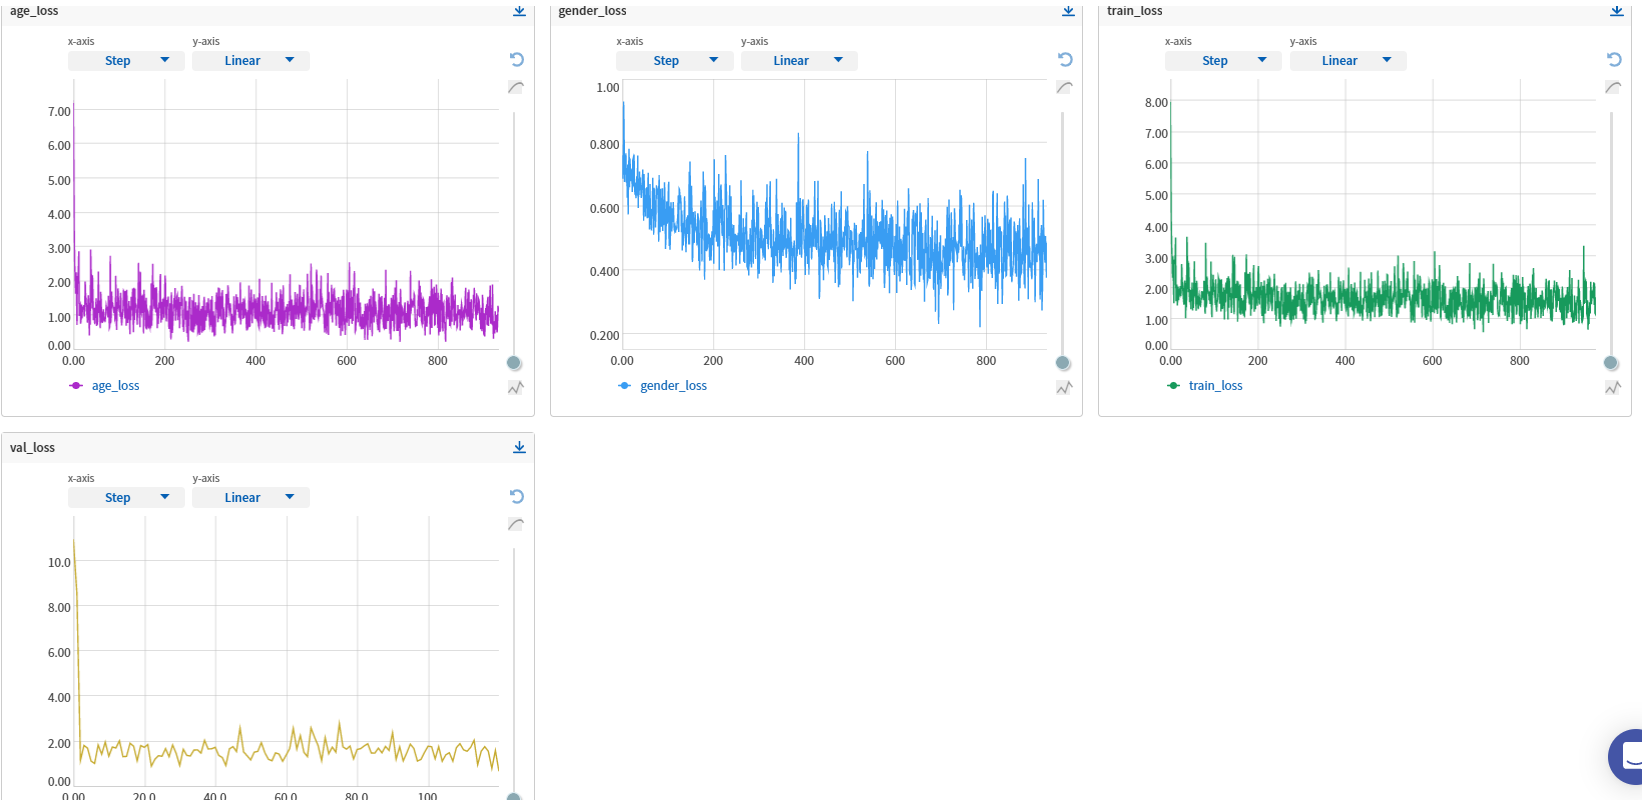

most important graph is validation loss and it seems that our model has converged, so further training wouldn't help.

## evaluation

### performance

In [28]:
def load_eval_model(path):
    model = MTLModel.load_from_checkpoint(path)
    return model.eval().to(device)

In [29]:
model = load_eval_model("/content/435-20210924-151320.ckpt")
model = model.to(device)

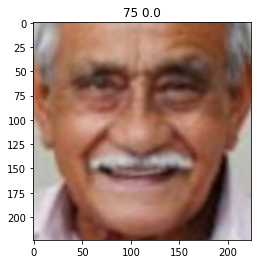

In [30]:
id = randrange(len(df_test))
test_dataset.show(id)

In [31]:
age, gender = model(test_dataset[id]["img"].unsqueeze(0).to(device))
int(np.exp(age.item())), gender.item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(23, 0.03135516867041588)

In [32]:
def model_eval(model, loader):
    results = [] 
    with torch.no_grad():
        for i, batch in enumerate(loader):
            img = batch['img'].to(device) # image
            pred_age, pred_gender = model(img) # preds

            true_age = batch['labels']['age'].cpu().numpy()
            true_age = list(map(lambda x: int(np.exp(x)), true_age))

            true_gen = batch['labels']['gender'].cpu().numpy()

            pred_age = pred_age.cpu().numpy().squeeze(1)
            pred_age = list(map(lambda x: int(np.exp(x)), pred_age))
            pred_gen = pred_gender.cpu().numpy().squeeze(1)

            for i in range(len(batch['labels']['age'])):
                item = {
                    'img': batch['img'][i].cpu(),
                    'age': true_age[i],
                    'gen': true_gen[i],
                    'pred_age': pred_age[i],
                    'pred_gen': pred_gen[i]
                }
                results.append(item)
    return results

In [33]:
results = model_eval(model, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [34]:
results[0] # structure of the results 

{'age': 24,
 'gen': 1.0,
 'img': tensor([[[ 0.8276,  0.9040,  1.0207,  ..., -1.3852, -1.3987, -1.3987],
          [ 0.8276,  0.8903,  1.0054,  ..., -1.3852, -1.3987, -1.3987],
          [ 0.8141,  0.8872,  0.9930,  ..., -1.3852, -1.4001, -1.4121],
          ...,
          [ 0.3481,  0.3939,  0.4532,  ...,  1.1276,  1.1473,  1.1505],
          [ 0.3499,  0.3957,  0.4550,  ...,  1.1487,  1.1911,  1.2080],
          [ 0.3652,  0.4110,  0.4703,  ...,  1.1640,  1.2080,  1.2385]],
 
         [[ 0.6604,  0.7385,  0.8166,  ..., -1.4618, -1.4755, -1.4755],
          [ 0.6604,  0.7245,  0.8010,  ..., -1.4618, -1.4755, -1.4755],
          [ 0.6466,  0.7214,  0.7883,  ..., -1.4510, -1.4770, -1.4892],
          ...,
          [-0.0574, -0.0106,  0.0501,  ...,  0.8096,  0.8296,  0.8330],
          [-0.0555, -0.0087,  0.0519,  ...,  0.8311,  0.8744,  0.8917],
          [-0.0399,  0.0070,  0.0676,  ...,  0.8467,  0.8917,  0.9230]],
 
         [[ 0.5311,  0.6088,  0.6729,  ..., -1.2679, -1.2816, -1.281

In [35]:
# check that all the predictions were made
assert len(results) == len(test_dataset) 

#### on gender performance

In [36]:
thresh = 0.5 # threshold for when a prediction is a woman
y_true_gen =  [p['gen'] for p in results]
y_pred_gen = [1 if p['pred_gen'] > thresh else 0 for p in results]

[Text(0.5, 1.0, 'Gender conf matrix')]

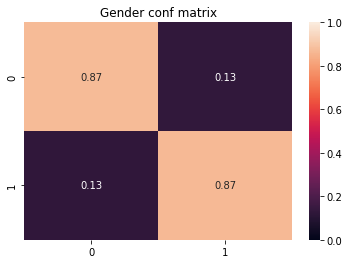

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_mat = confusion_matrix(y_true_gen, y_pred_gen, normalize='pred')

plt.figure()
sns.heatmap(pd.DataFrame(conf_mat), annot=True, vmin=0, vmax=1).set(title="Gender conf matrix")

In [38]:
print("Gender report")
print(classification_report(y_true_gen, y_pred_gen))

Gender report
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       519
         1.0       0.87      0.84      0.86       430

    accuracy                           0.87       949
   macro avg       0.87      0.87      0.87       949
weighted avg       0.87      0.87      0.87       949



As a basic performance metric we can choose accuracy. It has 83% while state of the art accuracy is around 95%. Clearly there is room for improvment. Keeping in mind that the model has 2 tasks and is quite simple I'm happy with this performance.

#### on age performance

In [39]:
y_true_age = [p['age'] for p in results]
y_pred_age = [p['pred_age'] for p in results]

In [40]:
from sklearn.metrics import mean_squared_error
print("Age report")
print(mean_squared_error(y_true_age, y_pred_age, squared=False))

Age report
21.946457500899268


Text(0.5, 1.0, 'True age vs pred age')

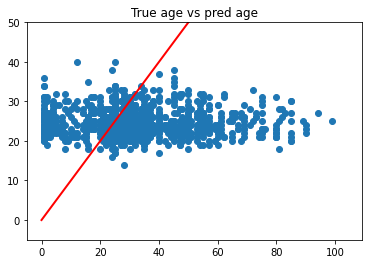

In [41]:
plt.scatter(y_true_age, y_pred_age)
plt.plot([0, 80], [0, 80], color = 'red', linewidth = 2)
plt.xlim(-5, max(y_true_age)+10)
plt.ylim(-5, max(y_pred_age)+10)
plt.title("True age vs pred age")

(-4.0, 104.0)

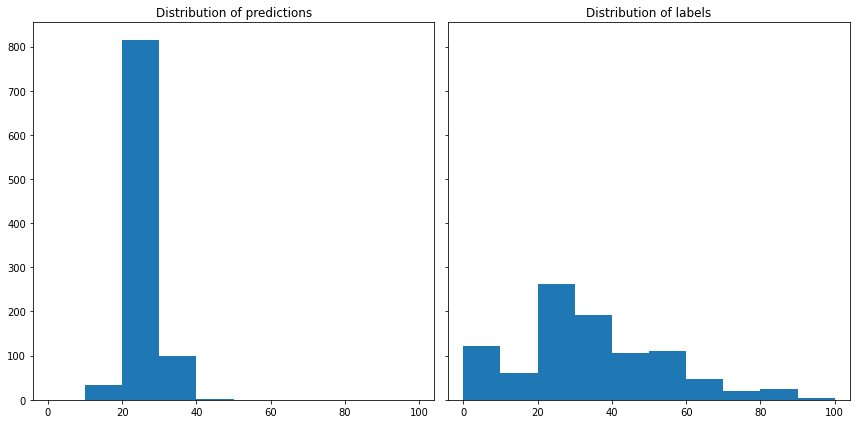

In [42]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(12, 6))
bins = [i*10 for i in range(11)]
axs[0].hist(y_pred_age, bins=bins)
axs[1].hist(y_true_age, bins=bins)

axs[0].title.set_text("Distribution of predictions")
axs[0].set_xlim(min(y_true_age)-5, max(y_true_age)+5)
axs[1].title.set_text("Distribution of labels")
axs[1].set_xlim(min(y_true_age)-5, max(y_true_age)+5)

Age reggresion is the week part of the model. It clearly overfit to predict younger people. This could be because of the log transformation earlier. Or many samples in the training data. Model shoul not be used to make age predictions.

## ethics

In [61]:
def show(item, extra=None):
        x = item['img']
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means) * 255).astype(np.uint8)
        plt.imshow(img)
        plt.title((f"True age: {item['age']}, gender: {item['gen']}; \
        Predicted age: {item['pred_age']}, gender: {np.round(item['pred_gen'])}"))
        if extra:
            plt.figtext(0.5, 0.01, extra, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

867


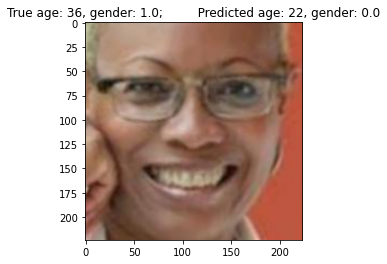

In [ ]:
n = randrange(len(test_dataset))

print(n)
show(results[n])

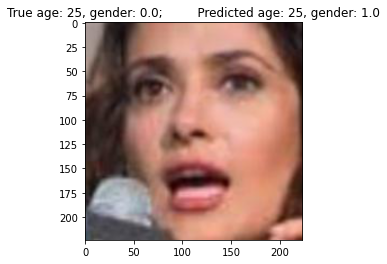

In [ ]:
show(results[841])

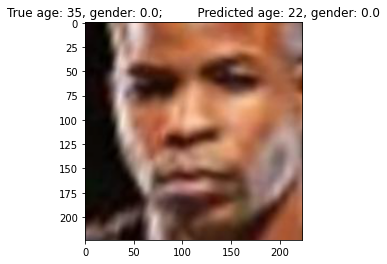

In [ ]:
show(results[923])

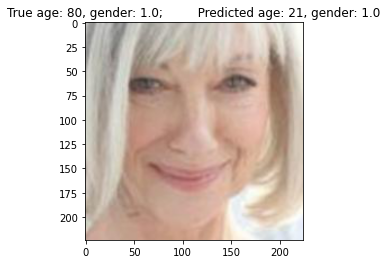

In [ ]:
show(results[67])

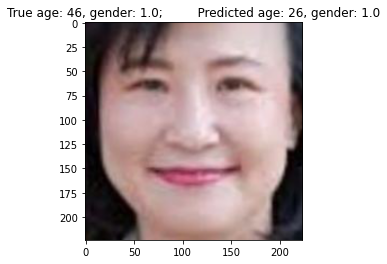

In [ ]:
show(results[819])

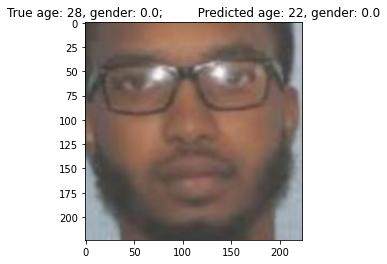

In [ ]:
show(results[566])

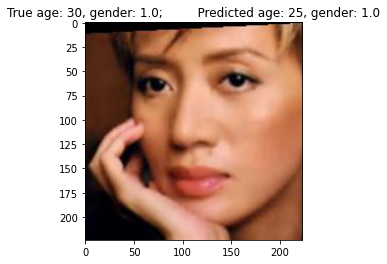

In [ ]:
show(results[272])

Examples show that gender is predicted way better than age.

## Lime, again...

In [ ]:
!pip install lime -q

     |████████████████████████████████| 275 kB 13.5 MB/s 


In [ ]:
def batch_predict(img):
    img = img.reshape(-1, 3, IMG_SIZE, IMG_SIZE)
    img = torch.tensor(img)
    age, gender = model(img)
    prob_woman = gender.detach().cpu().numpy()
    prob_man = 1 - prob_woman
    return np.concatenate((prob_woman, prob_man), axis=1)

In [ ]:
img = np.array(test_dataset[0]["img"]).reshape(IMG_SIZE, IMG_SIZE, 3)
batch_predict(img).shape

(1, 2)

In [ ]:
def transform_lime(img):
    img = img.reshape(3, IMG_SIZE, IMG_SIZE)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    img = ((img.transpose((1,2,0))*stds + means) * 255).astype(np.uint8)
    return img

def show_lime(img):
    plt.imshow(transform_lime(img))

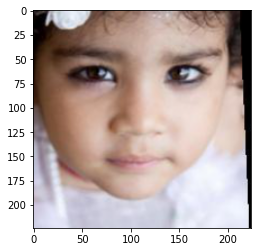

In [ ]:
id = 53
show_lime(np.array(test_dataset[id]["img"]))

In [ ]:
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(test_dataset[id]["img"]).reshape(IMG_SIZE, IMG_SIZE, 3), # data 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from skimage.segmentation import mark_boundaries

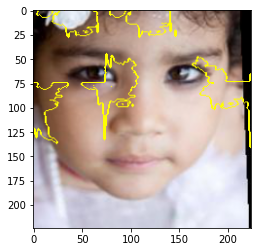

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(transform_lime(temp), mask)
plt.imshow(img_boundry1)

## best/worst cases

In [54]:
from sklearn.metrics import mean_squared_error


def log_loss(y, p):
    # log loss from sklearn website
    return -(y * np.log(p) + (1-y)*np.log(1-p))

def find_best_worst():
    MSELoss = nn.MSELoss()
    CrossEntropy = nn.BCELoss()

    for r in results:
        age_loss = mean_squared_error([r["age"]], [r["pred_age"]])

        gen_loss = log_loss(r["gen"], r["pred_gen"])
        r["age_loss"] = age_loss
        r["gen_loss"] = gen_loss

find_best_worst()

### by gender

In [ ]:
results.sort(key= lambda x: x['gen_loss'])

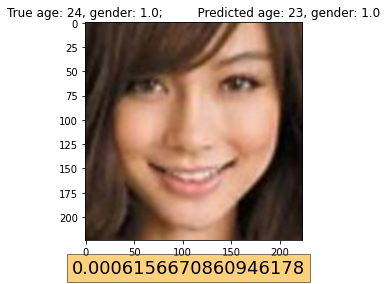

In [63]:
# best
show(results[0], results[0]['gen_loss'])

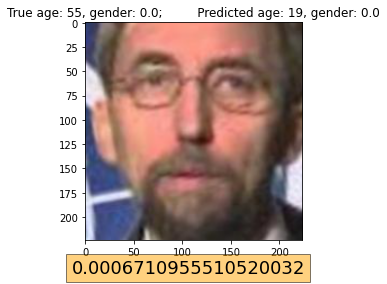

In [64]:
show(results[1], results[1]['gen_loss'])

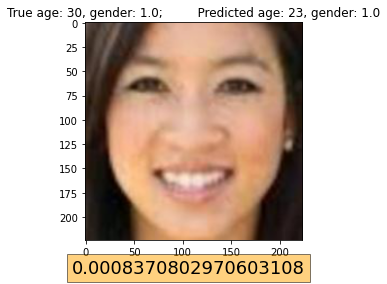

In [66]:
show(results[2], results[2]['gen_loss'])

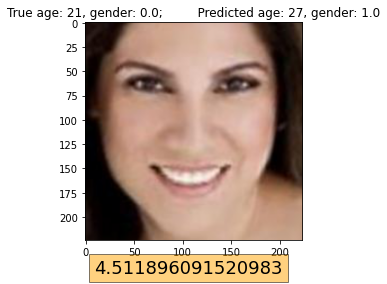

In [67]:
# worst
show(results[-1], results[-1]['gen_loss'])

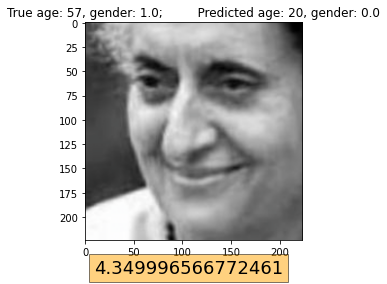

In [68]:
show(results[-2], results[-2]['gen_loss'])

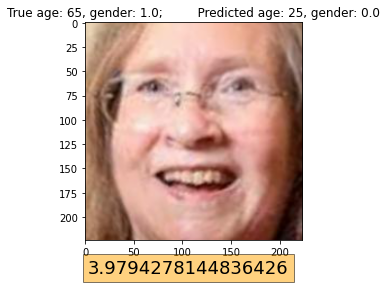

In [69]:
show(results[-3], results[-3]['gen_loss'])

### by age

In [70]:
results.sort(key= lambda x: x['age_loss'])

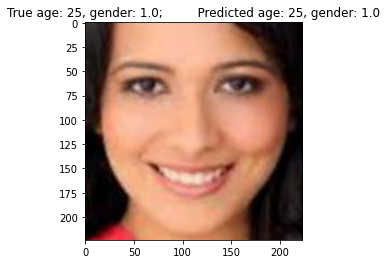

In [71]:
# best
show(results[0], results[0]['age_loss'])

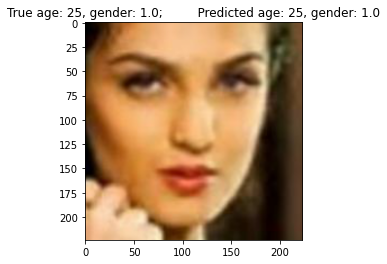

In [73]:
show(results[1], results[1]['age_loss'])

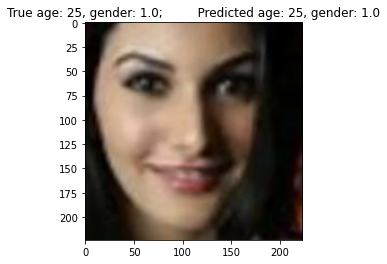

In [74]:
show(results[2], results[2]['age_loss'])

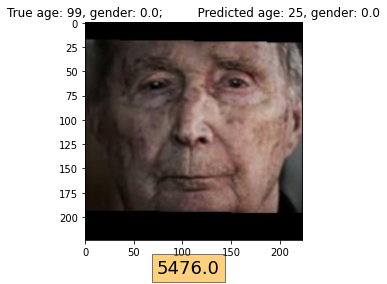

In [75]:
# worst
show(results[-1], results[-1]['age_loss'])

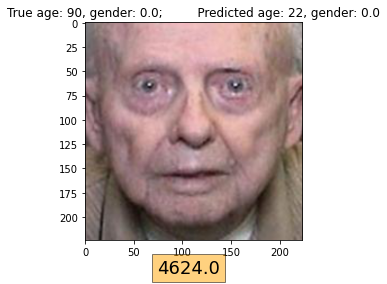

In [76]:
show(results[-2], results[-2]['age_loss'])

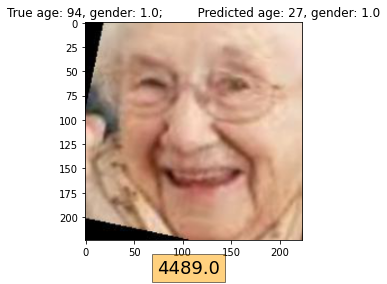

In [77]:
show(results[-3], results[-3]['age_loss'])

## conclusions

From the examples we can see a few things:

1) Model is biased to predict age around 20-30 (which was a one of the concerns raised in EDA).
2) Model struggles to predict younger people, especially babies and children. 
3) Older people tend to be given younger ages.

4) Gender predictions in general are decent.



As model is biasd to predict age around 20/30, this raises a few ethical concerns:

Some people will be predicted to be older, while others younger, then they are really. This means that information received by this model shouldn't be used as a proof of age. To sell alcohol for example.

Biggest bias comes from bad quality images and a lack of balance in training set.

Having a dataset, which represents real world scenarios (creating model while having a clear set goal) and using better quality images should reduce the bias.

Models ability to predict the gender is decent so that should be its main job. While age discrimination is poor, it should do a fair job with young adults/ people up to 30. 

One use case would be using it in a shop, to gather information regarding visiting peoples gender. This could be combined with purchasing record to see distributions of visitors vs buyers and this information could be used to make advertising decisions.

Bad case scenarios would be anything which includes the need to discriminate young people from older ones. 

## Concepts to explore

- Classification task
- Convolutional neural network
- AI ethics and bias
- Model interpretability

## Requirements

- You should go through the standard cycle of EDA-model-evaluation.
- Create a single model that returns age and gender in a single pass
- Analyze model performance
- Understand, which are the best/worst performing samples.
- Use LIME for model interpretability with images. Understand what you model

Once you are done with these tasks, evaluate any ethical issues with this model

- Identify how this model can be biased and check if the results show signs of these issues.
- Analyze bad predictions. Do you see any patterns in misclassified samples, that can cause ethical concerns?
- Describe in which scenarios your model can be biased. Propose solutions to mitigate it.
- Think of a domain, where this model could/could-not be deployed.

## Evaluation criteria

- EDA
- A single end-to-end trainable deep learning model is built
- Correctly modeled classification/regression
- Correct selection of loss function(s)
- Model interpretability tools used and insights made
- Model aggregate performance
- Quality of ethical concerns raised
- Code quality


## Sample correction questions

During a correction, you may get asked questions that test your understanding of covered topics.

- What advantages does building ML model in iterations bring over non-iterative approach.
- You are given 2 million images out of which only 1000 has labels. You are asked to build an image classifier. Explain how would you address the problem with the help of auto-encoders.
- When training ML models, an engineer often has to compromise between inference speed and performance (e.g. accuracy, f1). Explain in what scenarios would you choose performance over speed and vice-versa.
- What is negative feedback loop in ML models. Give an example and explain what (if anything) can be done to avoid it.